# RNN  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

C:\Users\mazen\AppData\Local\Temp\ipykernel_10100\2461584111.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
D = 28*28
n = 256
C = 1

classes = 10

model_regular = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(D, n), 
    nn.Tanh(), 
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n), 
    nn.Tanh(), 
    nn.Linear(n, classes), 
)

In [3]:
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), 
    nn.Tanh(), h_2,
    nn.Tanh(), h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

# Lets build an RNN network 

In [6]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [7]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 


Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [8]:
namge_language_data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [9]:
# Show the first 10 Arabic names in the dataset
print("First 10 Arabic names in the dataset:")
for i, name in enumerate(namge_language_data["Arabic"][:10], 1):
    print(f"{i}. {name}")

First 10 Arabic names in the dataset:
1. khoury
2. nahas
3. daher
4. gerges
5. nazari
6. maalouf
7. gerges
8. naifeh
9. guirguis
10. baba


In [10]:
class LanguageNameDataset(Dataset):
    '''
    self.label_names becomes ['English', 'Spanish', 'Japanese']
    self.data becomes ['Smith', 'Johnson', 'Williams', 'Garcia', 'Rodriguez', 'Lopez', 'Tanaka', 'Suzuki', 'Sato']
    self.labels becomes [0, 0, 0, 1, 1, 1, 2, 2, 2] (0 for English, 1 for Spanish, 2 for Japanese)

    Now, let's see what happens when we access a specific item, for example dataset[4]:

    The __getitem__ method is called with idx=4
    It retrieves name = self.data[4] which is 'Rodriguez'
    It retrieves label = self.labels[4] which is 1 (Spanish)
    It calls self.string2InputVec('Rodriguez') which does the following:

    Creates a tensor of zeros with length 9 (number of characters in "Rodriguez")
    For each character, it replaces the zeros with the corresponding integer from the vocabulary:

    'R' → 44
    'o' → 15
    'd' → 4
    'r' → 18
    'i' → 9
    'g' → 7
    'u' → 21
    'e' → 5
    'z' → 26


    This creates the tensor: tensor([44, 15, 4, 18, 9, 7, 21, 5, 26])


    It converts the label 1 to a tensor: tensor([1])
    It returns the tuple: (tensor([44, 15, 4, 18, 9, 7, 21, 5, 26]), tensor([1]))
    '''
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        # Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label


In [11]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

def collate_batch(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels)  
    return padded_sequences, lengths, labels

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_batch)

In [12]:
# example of embedding
# ammae
'input sequence with T = 5 items but a vocabulary of only 3 items'
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[-0.3610, -1.3081],
        [-1.3243, -0.6962],
        [-1.3243, -0.6962],
        [-0.3610, -1.3081],
        [-1.3172,  0.2047]])


In [13]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed)
        
        # For bi-directional, concatenate final forward & backward hidden states
        if self.lstm.bidirectional:
            out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            out = hidden[-1]

        return self.fc(out)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, lengths, y in dataloader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x, lengths)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            preds = model(x, lengths)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(alphabet)
embed_dim = 32
hidden_dim = 64
output_dim = len(dataset.label_names)
epochs = 5
# Stacked LSTM (2 layers)
model_stacked = CharLSTM(vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2).to(device)
opt_stacked = optim.Adam(model_stacked.parameters())
criterion = nn.CrossEntropyLoss()

# Bi-directional LSTM (1 layer)
model_bi = CharLSTM(vocab_size, embed_dim, hidden_dim, output_dim, bidirectional=True).to(device)
opt_bi = optim.Adam(model_bi.parameters())

In [25]:
# Train stacked
loss_stacked=[]
for epoch in range(epochs):
    loss_stacked.append(train(model_stacked, train_loader, opt_stacked, criterion, device))
acc_stacked = evaluate(model_stacked, test_loader, criterion, device)

# Train bi-directional
loss_bi=[]
for epoch in range(epochs):
    loss_bi.append(train(model_bi, train_loader, opt_bi, criterion, device))
acc_bi = evaluate(model_bi, test_loader, criterion, device)

print(f"Accuracy (Stacked): {acc_stacked:.4f}")
print(f"Accuracy (Bi-Directional): {acc_bi:.4f}")


Accuracy (Stacked): 0.7800
Accuracy (Bi-Directional): 0.8000


### 🔍 Summary

We compared two LSTM architectures on the character-level language name classification task:
- **Stacked LSTM (2 layers)** achieved 78% accuracy
- **Bi-directional LSTM (1 layer)** achieved 80% accuracy

This suggests that depth helped more than bi-directionality in this task.


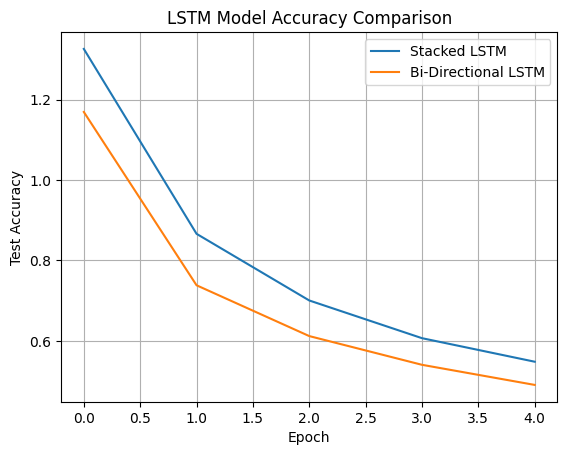

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), loss_stacked, label='Stacked LSTM')
plt.plot(range(epochs), loss_bi, label='Bi-Directional LSTM')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('LSTM Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()
